In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Data

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read File

In [ ]:
# Specify the file path within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/hmnist_28_28_RGB.csv'  # Replace with your actual file path

# Read the file using Pandas (assuming it's a CSV file)
df = pd.read_csv(file_path)

# Data Preprocessing

Take out the label

In [ ]:
y = df['label']
x = df.drop(columns = ['label'])

In [ ]:
print(x.shape)

(10015, 2352)


Oversample to handle class imbalance

In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler()
#x,y  = oversample.fit_resample(x,y)

Specify Labels

In [ ]:
print(y.nunique())

7


In [ ]:
print(y.value_counts())
#nv       6705 benign
#mel      1113 malignant
#bkl      1099 benign
#bcc       514 malignant
#akiec     327 malignant
#vasc      142 benign
#df        115 benign

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


Replace 4, 2, 5, 3 with benign (0), and rest with malignant (1)

In [ ]:
# Replace values 1, 6, 0 with 1
y.replace({1: 1, 6: 1, 0: 1}, inplace=True)

# Replace values 4, 2, 5, and 3 with 0
y.replace({4: 0, 2: 0, 5: 0, 3: 0}, inplace=True)

In [ ]:
print(y.value_counts())
# benign 8061
# malignant 1954

0    8061
1    1954
Name: label, dtype: int64


Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
print(y.value_counts())

0    8061
1    8061
Name: label, dtype: int64


Reshape data

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (16122, 28, 28, 3)


Convert Shape

In [ ]:
from scipy.ndimage import zoom

images = x

# Define the desired size (224x224)
desired_size = (72, 72)

# Upscale the images using interpolation
upscaled_images = np.zeros((images.shape[0],) + desired_size + (3,))
for i in range(images.shape[0]):
    for channel in range(3):
        upscaled_images[i, :, :, channel] = zoom(images[i, :, :, channel],
                                                 (desired_size[0] / images.shape[1], desired_size[1] / images.shape[2]))
print(upscaled_images.shape)

(16122, 72, 72, 3)


In [ ]:
x = upscaled_images
print(x.shape)

(16122, 72, 72, 3)


Standardization

In [ ]:
x = (x-np.mean(x))/np.std(x)

Train-Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
print(Y_train.value_counts())
print(Y_test.value_counts())

1    6451
0    6446
Name: label, dtype: int64
0    1615
1    1610
Name: label, dtype: int64


# Model Training

SqueezeNet Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, Concatenate, MaxPool2D, GlobalAvgPool2D, Activation
def squeezenet(input_shape, n_classes):

  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output


  input = Input(input_shape)

  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)

  output = Activation('sigmoid')(x)

  model = Model(input, output)
  return model

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()

In [ ]:
INPUT_SHAPE = (72, 72, 3)
N_CLASSES = 1
model = squeezenet(INPUT_SHAPE, N_CLASSES)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 36, 36, 96)           14208     ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 18, 18, 96)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 18, 18, 16)           1552      ['max_pooling2d[0][0]']   

In [ ]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 50,
                    callbacks=[callback])

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5153
Epoch 1: saving model to best_model.h5
81/81 [==============================] - 25s 85ms/step - loss: 0.6920 - accuracy: 0.5153 - val_loss: 0.6933 - val_accuracy: 0.4977
Epoch 2/50
 1/81 [..............................] - ETA: 3s - loss: 0.6926 - accuracy: 0.5234

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/81 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5337
Epoch 2: saving model to best_model.h5
81/81 [==============================] - 4s 49ms/step - loss: 0.6829 - accuracy: 0.5346 - val_loss: 0.6820 - val_accuracy: 0.5620
Epoch 3/50
80/81 [============================>.] - ETA: 0s - loss: 0.5959 - accuracy: 0.6686
Epoch 3: saving model to best_model.h5
81/81 [==============================] - 4s 54ms/step - loss: 0.5956 - accuracy: 0.6683 - val_loss: 0.5289 - val_accuracy: 0.7190
Epoch 4/50
81/81 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7278
Epoch 4: saving model to best_model.h5
81/81 [==============================] - 4s 55ms/step - loss: 0.5135 - accuracy: 0.7278 - val_loss: 0.5071 - val_accuracy: 0.7236
Epoch 5/50
81/81 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.7336
Epoch 5: saving model to best_model.h5
81/81 [==============================] - 4s 49ms/step - loss: 0.4969 - accuracy: 0.7336 -

# Plot Model Progression

Accuracy (training vs validation dataset)

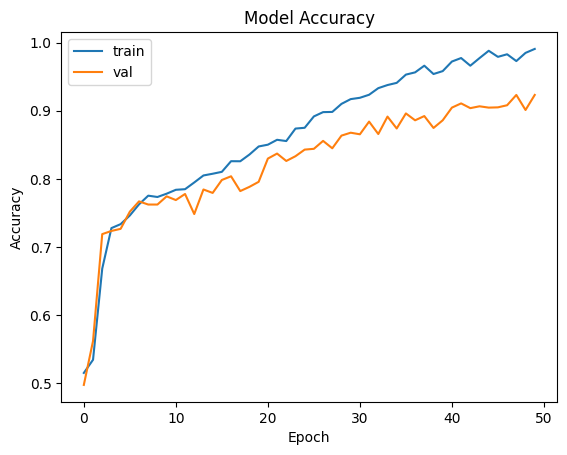

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

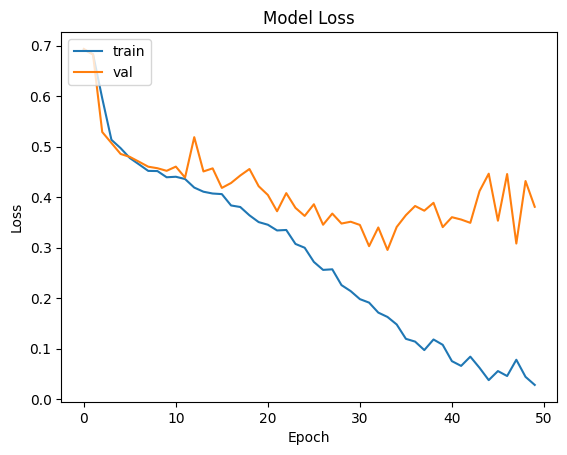

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load best model weights

In [ ]:
model.load_weights('best_model.h5')

Print model weights

In [ ]:
# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_model.h5')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_model_squeezenet.h5')

# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())

Layer: conv2d
  conv2d/kernel:0:
[[[[-1.12763725e-01 -1.60510242e-02  8.48663971e-02 ... -6.64739460e-02
     7.24145174e-02  6.20905496e-02]
   [ 2.91653294e-02 -6.69543305e-03  1.03266768e-01 ... -1.57749075e-02
    -1.04694264e-02 -1.46020763e-02]
   [-4.70504574e-02  2.36108974e-02  2.25594923e-01 ...  7.11699799e-02
     8.88718199e-03 -3.41867609e-03]]

  [[-6.69350475e-02 -1.58280712e-02  6.59974888e-02 ... -3.90672460e-02
     7.43885636e-02  8.98841694e-02]
   [-5.65283094e-03  3.68204191e-02  1.24306113e-01 ...  2.66629290e-02
    -4.24927212e-02 -4.76050042e-02]
   [-4.08676527e-02  4.32467647e-02  2.31894389e-01 ...  3.33657973e-02
     4.59455997e-02 -6.39273226e-03]]

  [[-2.70692743e-02 -4.55195606e-02  5.48662730e-02 ...  1.53125508e-03
     8.22243840e-02  3.46960761e-02]
   [-1.15018217e-02 -1.22422865e-02  1.00366071e-01 ... -6.53931824e-03
    -3.81225254e-03 -3.96003351e-02]
   [-4.21725661e-02  5.65810390e-02  2.08586335e-01 ...  8.46588090e-02
     1.39593426e-02

# Model Testing

In [ ]:
#loss, acc = model.evaluate(X_test, Y_test, verbose=2)

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

101/101 [==============================] - 2s 9ms/step


In [ ]:
print(y_pred_ohe)

[[3.0785674e-01]
 [3.3617817e-11]
 [1.5904254e-01]
 ...
 [9.6070817e-06]
 [9.9993420e-01]
 [8.6240633e-11]]


In [ ]:
threshold = 0.7
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [ ]:
# Save predictions as a NumPy array
np.save('squeezenet_predictions.npy', y_pred_labels)

In [ ]:
print(y_pred_labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[1474  141]
 [  90 1520]]


In [ ]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.94      0.91      0.93      1615
   malignant       0.92      0.94      0.93      1610

    accuracy                           0.93      3225
   macro avg       0.93      0.93      0.93      3225
weighted avg       0.93      0.93      0.93      3225



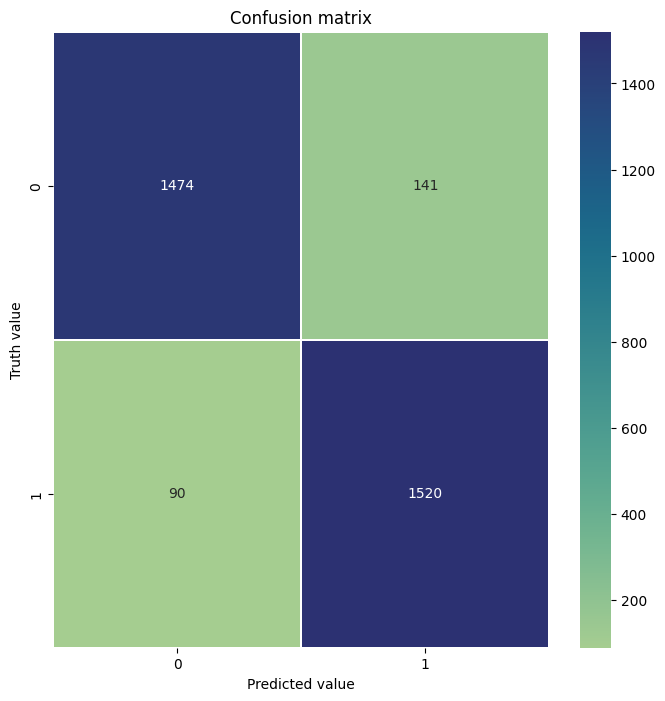

In [ ]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.93
Precision: 0.92
Recall: 0.94
F1-score: 0.93


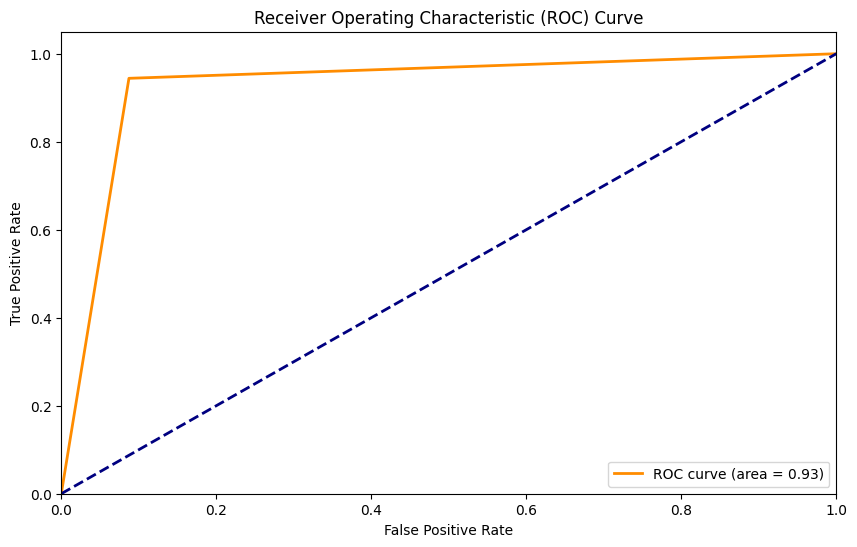

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()